This notebook goes over the process of creating, tuning and testing all of the predictive modeling features in this program.

I will start by first creating an optimal model to predict how many tournament wins (`Wins`) each team should earn based on how their statistical profile matches up with past teams.

To start, we need to import the dataset:

In [593]:
import pandas as pd

data = pd.read_csv("data/data_official.csv")

data

,YEAR,CONF,CONF ID,QUAD NO,QUAD ID,TEAM NO,TEAM ID,TEAM,SEED,ROUND,...,BADJT RANK,AVG HGT RANK,EFF HGT RANK,EXP RANK,TALENT RANK,FT% RANK,OP FT% RANK,PPPO RANK,PPPD RANK,ELITE SOS RANK
0,2025,MAC,17,66,2,1147,2,Akron,13,0,...,19,361,364,73,149,86,239,25,145,305
1,2025,SEC,28,66,2,1146,3,Alabama,2,0,...,1,57,4,261,32,211,92,9,174,1
2,2025,SWAC,31,68,4,1145,4,Alabama St.,16,0,...,154,285,239,83,251,270,61,227,147,253
3,2025,Pat,25,66,2,1144,6,American,16,0,...,349,303,248,181,364,58,34,218,163,329
4,2025,B12,7,66,2,1143,8,Arizona,4,0,...,52,74,129,225,16,18,143,25,87,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142,2008,BE,8,1,1,5,235,West Virginia,7,16,...,225,18,115,181,61,209,16,22,32,49
1143,2008,SB,26,1,1,4,236,Western Kentucky,12,16,...,111,160,179,55,131,127,214,27,28,203
1144,2008,BSth,10,4,4,3,239,Winthrop,13,64,...,301,231,206,89,236,339,190,170,12,179
1145,2008,B10,6,3,3,2,240,Wisconsin,3,16,...,301,51,35,98,12,118,117,60,2,57


Next let's drop all of the categorical features and features that do not make sense to include in this model:

In [594]:
drop = ["YEAR", "CONF", "TEAM", "CONF ID", "QUAD ID", "QUAD NO", "TEAM NO", "TEAM ID", "ROUND"]

df = data.drop(drop, axis=1)

columns = df.columns.to_list()

Now that we have our `df` saved, let's see which features most **strongly** correlate to `Wins`:

In [595]:
corr = abs(df.corr()["Wins"]).sort_values(ascending=False)
filtered = corr[corr >= 0.1]
print(filtered.sort_values(ascending=False).index)

Index(['Wins', 'SEED', 'WAB', 'BADJ EM', 'KADJ EM', 'BADJ O', 'KADJ O',
       'TALENT', 'BARTHAG', 'BARTHAG RANK', 'BADJ EM RANK', 'KADJ EM RANK',
       'KADJ D', 'ELITE SOS', 'BADJ D', 'W', 'ELITE SOS RANK', 'TALENT RANK',
       'BADJ O RANK', 'KADJ O RANK', 'BADJ D RANK', 'WIN%', 'KADJ D RANK',
       'PPPO', 'L', 'K OFF', 'PPPO RANK', 'KO RANK', 'AVG HGT', 'PPPD',
       'AVG HGT RANK', 'K DEF', 'EFF HGT', 'EFF HGT RANK', 'PPPD RANK',
       'KD RANK', 'OREB% RANK', 'OP DREB% RANK', 'EFG%D', 'OP DREB%', 'OREB%',
       'EFGD% RANK', 'BLK%', '2PT%D', 'TOV% RANK', '2PT%D RANK', 'EFG%',
       'BLK% RANK', 'EFG% RANK', '2PT%', 'GAMES', 'TOV%', '2PT% RANK', 'FTRD',
       'FTRD RANK', 'EXP', '3PT%D', 'BLKED% RANK', '3PT%D RANK', 'BLKED%',
       'EXP RANK', '3PT% RANK', '3PT%'],
      dtype='object')


Once I had this list, I repeated a trial and error process of removing features that were too strongly correlated with each other until I found an "optimal" set of features.

To test how "optimal" these features were, I removed:

    - Features that were strongly correlated with other features
    - Features that had a high Variance Inflation Factor "VIF"
    - Features I deemed as less important using my prior knowledge of basketball statistics 

In [596]:
optimal = ['WAB','KADJ O', 'KADJ D', 'EFF HGT', 'OREB%', '2PT%D', 'TOV%', 'FTRD', 'EXP', '3PT%D', '3PT%']

The creation of the correlation matrix to test for correlation between features:

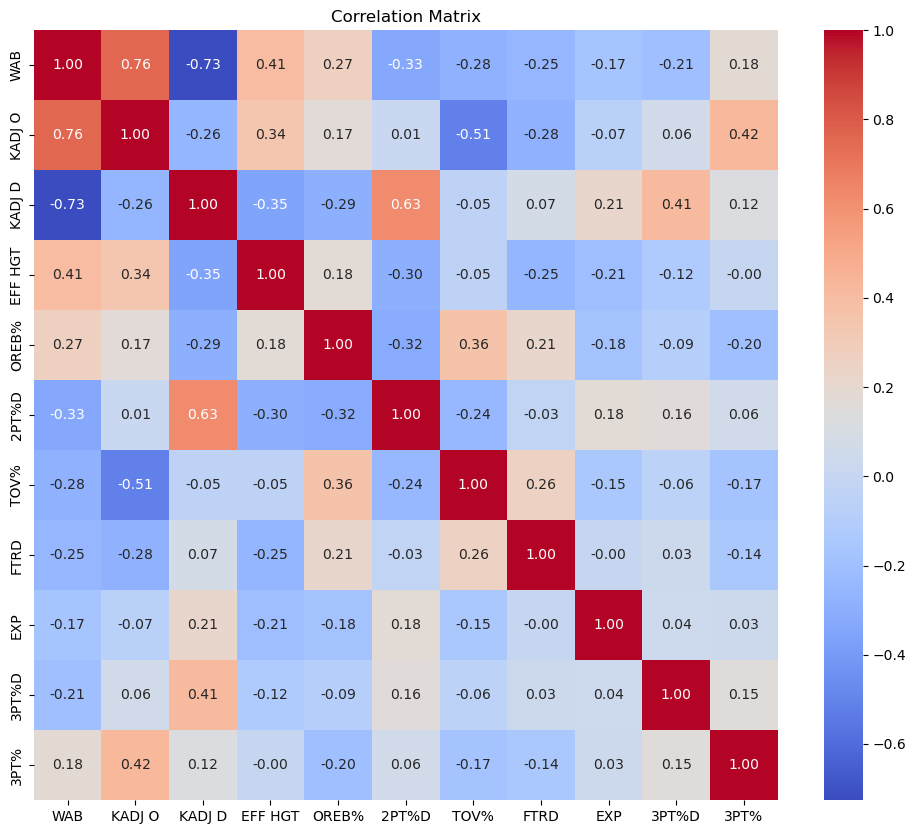

In [597]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

corr_matrix = df[optimal].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

The creation of the VIF model that shows which features are causing the model to be most unstable. Features were removed until they all scored below 10:

In [598]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df[optimal]
X = add_constant(X)  

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))

    Feature          VIF
0     const  9613.663721
1       WAB     8.283188
2    KADJ O     6.423751
3    KADJ D     5.310082
7      TOV%     2.137940
6     2PT%D     2.067686
5     OREB%     1.905823
11     3PT%     1.630217
4   EFF HGT     1.411473
10    3PT%D     1.315214
8      FTRD     1.257981
9       EXP     1.105952


In [599]:
optimal = ['WAB','KADJ O', 'KADJ D', 'EFF HGT', 'OREB%', '2PT%D', 'TOV%', 'FTRD', 'EXP', '3PT%D', '3PT%']

In [600]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import make_pipeline

data = pd.read_csv("data/data_official.csv")

years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024, 2025]

Now that I had my optimal set of features to predict `Wins`, it was time to create the poisson regression model that could predict a team's `Wins` based on selected predictors.

In [601]:
def get_proj_wins(x_train, x_test, y_train_series):

    model = make_pipeline(StandardScaler(), PoissonRegressor(alpha=0.3, max_iter=10000)) # Creates poisson regression model as model
    model.fit(x_train, y_train_series) # Fits model to training data
    y_pred = model.predict(x_test)     # Predicts outcome of testing data based on model
       
    return y_pred

def get_ranks(data_train, data_test):
    
    x_train = data_train[optimal]
    x_test = data_test[optimal]
    
    data_test.loc[:, 'Proj_Wins'] = get_proj_wins(x_train, x_test, data_train['Wins'])
    data_test.loc[:, 'Proj_Wins_Rank'] = data_test['Proj_Wins'].rank(ascending=False, method='min').astype(int)
    data_test.loc[:, 'Wins_Rank'] = data_test['Wins'].rank(ascending=False, method='min').astype(int)

    
    return data_test

ranks = []

for year in years:

    data_train = data[data['YEAR'] < year]
    data_test0 = data[data['YEAR'] == year].copy()

    data_test = get_ranks(data_train, data_test0)
    
    ranks.append(data_test)
   

 
df = pd.concat(ranks, axis=0)

df = df[['YEAR', 'QUAD ID', 'TEAM', 'SEED', 'Wins', 'Wins_Rank', 'Proj_Wins', 'Proj_Wins_Rank']].sort_values(by='Wins', ascending=False)

df

,YEAR,QUAD ID,TEAM,SEED,Wins,Wins_Rank,Proj_Wins,Proj_Wins_Rank
690,2014,3,Connecticut,7,6,1,1.008190,29
229,2022,1,Kansas,1,6,1,2.152343,5
509,2017,1,North Carolina,1,6,1,2.954497,1
276,2021,2,Baylor,1,6,1,2.032852,5
777,2013,4,Louisville,1,6,1,3.306904,1
...,...,...,...,...,...,...,...,...
410,2018,0,Arizona St.,11,0,33,0.516541,44
409,2018,4,Arizona,4,0,33,1.198006,15
541,2017,1,Winthrop,13,0,33,0.254144,56
538,2017,0,Wake Forest,11,0,33,0.753550,33


Just like that, I now had a dataset that contains each team for each year, their actual number of wins (`Wins`), and their projected number of wins (`Proj_Wins`), which is calculated based on their data **PRIOR** to their tournament compared to teams' data from **PRIOR** seasons.

Now it is time to test how well this model performs. To do this, I created a program that accurately simulates a bracket. In each matchup of each round it advances the team with the higher `Proj_Wins` calculated by the model I created.

In [602]:
df['Sim_Wins'] = [-1 for _ in range(len(df))]

def same_seed(df, seed):
    
    subdf = pd.DataFrame(df[df["SEED"] == seed])
    team1 = subdf.head(1)
    team1index = team1["TEAM"].index
    team2 = subdf.tail(1)
    team2index = team2["TEAM"].index

    if team1["Proj_Wins"].iloc[0] > team2["Proj_Wins"].iloc[0]:
        df.loc[team2index, "Sim_Wins"] = 0

    else:
        df.loc[team1index, "Sim_Wins"] = 0
        
    return df

def round64(df):
    
    subdf = df.loc[df["Sim_Wins"] == -1]
    
    seeds1 = [1,2,3,4,5,6,7,8]
    seeds2 = [16,15,14,13,12,11,10,9]
    
    for i in range(0,8):
        
        rdf = subdf[(subdf["SEED"] == seeds1[i]) | (subdf["SEED"] == seeds2[i])]
        team1 = rdf.head(1)
        team1index = team1["TEAM"].index
        team2 = rdf.tail(1)
        team2index = team2["TEAM"].index
        
        if team1["Proj_Wins"].iloc[0] > team2["Proj_Wins"].iloc[0]:
            df.loc[team2index, "Sim_Wins"] = 0
            
        else:
            df.loc[team1index, "Sim_Wins"] = 0
            
    return df

def round32(df):
    
    subdf = df[df["Sim_Wins"] == -1]
    
    team1 = subdf[(subdf["SEED"] == 1) | (subdf["SEED"] == 16)]
    team1index = team1["TEAM"].index
    team2 = subdf[(subdf["SEED"] == 8) | (subdf["SEED"] == 9)]
    team2index = team2["TEAM"].index
    if team1["Proj_Wins"].iloc[0] > team2["Proj_Wins"].iloc[0]:
        df.loc[team2index, "Sim_Wins"] = 1
    else:
        df.loc[team1index, "Sim_Wins"] = 1
    
    team3 = subdf[(subdf["SEED"] == 5) | (subdf["SEED"] == 12)]
    team3index = team3["TEAM"].index
    team4 = subdf[(subdf["SEED"] == 4) | (subdf["SEED"] == 13)]
    team4index = team4["TEAM"].index
    if team3["Proj_Wins"].iloc[0] > team4["Proj_Wins"].iloc[0]:
        df.loc[team4index, "Sim_Wins"] = 1
    else:
        df.loc[team3index, "Sim_Wins"] = 1
    
    team5 = subdf[(subdf["SEED"] == 6) | (subdf["SEED"] == 11)]
    team5index = team5["TEAM"].index
    team6 = subdf[(subdf["SEED"] == 3) | (subdf["SEED"] == 14)]
    team6index = team6["TEAM"].index
    if team5["Proj_Wins"].iloc[0] > team6["Proj_Wins"].iloc[0]:
        df.loc[team6index, "Sim_Wins"] = 1
    else:
        df.loc[team5index, "Sim_Wins"] = 1
    
    team7 = subdf[(subdf["SEED"] == 7) | (subdf["SEED"] == 10)]
    team7index = team7["TEAM"].index
    team8 = subdf[(subdf["SEED"] == 2) | (subdf["SEED"] == 15)]
    team8index = team8["TEAM"].index
    if team7["Proj_Wins"].iloc[0] > team8["Proj_Wins"].iloc[0]:
        df.loc[team8index, "Sim_Wins"] = 1
    else:
        df.loc[team7index, "Sim_Wins"] = 1
        
    return df

def sweet16(df):
    
    subdf = df[df["Sim_Wins"] == -1]
    
    options1 = [1,8,9,16]
    for i in options1:
        if not subdf[subdf["SEED"] == i].empty:
            team1 = subdf[subdf["SEED"] == i]
            break
    team1index = team1["TEAM"].index
    options2 = [4,5,12,13]
    for i in options2:
        if not subdf[subdf["SEED"] == i].empty:
            team2 = subdf[subdf["SEED"] == i]
            break
    team2index = team2["TEAM"].index
        
    if team1["Proj_Wins"].iloc[0] > team2["Proj_Wins"].iloc[0]:
        df.loc[team2index, "Sim_Wins"] = 2
    else:
        df.loc[team1index, "Sim_Wins"] = 2
        
    options3 = [3,6,11,14]
    for i in options3:
        if not subdf[subdf["SEED"] == i].empty:
            team3 = subdf[subdf["SEED"] == i]
            break 
    team3index = team3["TEAM"].index
    options4 = [2,7,10,15]
    for i in options4:
        if not subdf[subdf["SEED"] == i].empty:
            team4 = subdf[subdf["SEED"] == i]
            break
    team4index = team4["TEAM"].index
        
    if team3["Proj_Wins"].iloc[0] > team4["Proj_Wins"].iloc[0]:
        df.loc[team4index, "Sim_Wins"] = 2
    else:
        df.loc[team3index, "Sim_Wins"] = 2
        
    return df

def elite8(df):
    
    subdf = df[df["Sim_Wins"] == -1]
    
    options1 = [1,4,5,8,9,12,13,16]
    for i in options1:
        if not subdf[subdf["SEED"] == i].empty:
            team1 = subdf[subdf["SEED"] == i]
            break
    team1index = team1["TEAM"].index
    
    options2 = [2,3,6,7,10,11,14,15]
    for i in options2:
        if not subdf[subdf["SEED"] == i].empty:
            team2 = subdf[subdf["SEED"] == i]
            break
    team2index = team2["TEAM"].index
    
    if team1["Proj_Wins"].iloc[0] > team2["Proj_Wins"].iloc[0]:
        df.loc[team2index, "Sim_Wins"] = 3
    else:
        df.loc[team1index, "Sim_Wins"] = 3
        
    return df

def region_simulation(data, year, quad):
    
    seeds = list(range(1,17))
    
    df = data[(data["YEAR"] == year) & (data["QUAD ID"] == quad)]
    ###########################################################################
    # FIRST FOUR
    
    for seed in seeds:
    
        if df[df["SEED"] == seed].shape[0] > 1:
            
            df = same_seed(df, seed)
    ##########################################################################
    ##########################################################################
    # FIRST ROUND (R64)
        
    df = round64(df)
    
    ##########################################################################
    ##########################################################################
    # SECOND ROUND (R32)
    
    df = round32(df)
    
    ##########################################################################
    ##########################################################################
    # SWEET 16
    
    df = sweet16(df)
    
    ##########################################################################
    ##########################################################################
    # ELITE 8
    
    df = elite8(df)
    
    return df

def final4(df, year):
    
    subdf = df[df["Sim_Wins"] == -1]
    
    team1 = subdf[subdf["QUAD ID"] == 1]
    team1index = team1["TEAM"].index
        
    team2 = subdf[subdf["QUAD ID"] == 2]
    team2index = team2["TEAM"].index
        
    team3 = subdf[subdf["QUAD ID"] == 3]
    team3index = team3["TEAM"].index
        
    team4 = subdf[subdf["QUAD ID"] == 4]
    team4index = team4["TEAM"].index
        
    if team1["Proj_Wins"].iloc[0] > team2["Proj_Wins"].iloc[0]:
        df.loc[team2index, "Sim_Wins"] = 4
    else:
        df.loc[team1index, "Sim_Wins"] = 4
     
    if team3["Proj_Wins"].iloc[0] > team4["Proj_Wins"].iloc[0]:
        df.loc[team4index, "Sim_Wins"] = 4
    else:
        df.loc[team3index, "Sim_Wins"] = 4
        
    return df

def championship(df):
    
    subdf = df[df["Sim_Wins"] == -1]
    
    team1 = subdf.head(1)
    team1index = team1["TEAM"].index
    team2 = subdf.tail(1)
    team2index = team2["TEAM"].index
    
    if team1["Proj_Wins"].iloc[0] > team2["Proj_Wins"].iloc[0]:
        df.loc[team2index, "Sim_Wins"] = 5
        df.loc[team1index, "Sim_Wins"] = 6
    else:
        df.loc[team1index, "Sim_Wins"] = 5
        df.loc[team2index, "Sim_Wins"] = 6
        
    return df

def bracket_simulation(data, year):
    
    df1 = region_simulation(data, year, 1)
    df2 = region_simulation(data, year, 2)
    df3 = region_simulation(data, year, 3)
    df4 = region_simulation(data, year, 4)
    
    df = pd.concat([df1, df2, df3, df4])
    
    df = final4(df, year)
    
    df = championship(df)
                            
    return df

dfs = []

for year in years:
    
    dfs.append(bracket_simulation(df, year))
    
sim_df = pd.concat(dfs)
sim_df = sim_df[["YEAR", "TEAM", "SEED", "QUAD ID", "Proj_Wins", "Wins", "Sim_Wins"]]
df = sim_df.sort_values(["YEAR", "Sim_Wins", "Wins"], ascending=False)

df

,YEAR,TEAM,SEED,QUAD ID,Proj_Wins,Wins,Sim_Wins
15,2025,Duke,1,2,5.097104,4,6
16,2025,Florida,1,3,4.932930,6,5
21,2025,Houston,1,1,4.321864,5,4
6,2025,Auburn,1,4,4.621779,4,4
53,2025,Tennessee,2,1,3.118143,3,3
...,...,...,...,...,...,...,...
802,2013,Saint Mary's,11,4,0.878476,0,0
810,2013,Valparaiso,14,4,0.306551,0,0
789,2013,New Mexico St.,13,4,0.463962,0,0
786,2013,Missouri,9,4,0.975899,0,0


I now have a dataset that includes the results of each bracket simulated based on the outcome of my model, from 2013 to 2025. 

Each team's outcome can be seen in the `Sim_Wins` column, which displays how many games of the tournament they won in the simulation. (0 if they lost in the first round, 6 if they won the championship, etc.)

Let's see who the national champion should have been each year according to my model's simulation:

In [603]:
df[(df["Sim_Wins"] == 6)].head(15)

,YEAR,TEAM,SEED,QUAD ID,Proj_Wins,Wins,Sim_Wins
15,2025,Duke,1,2,5.097104,4,6
80,2024,Connecticut,1,4,3.964523,6,6
184,2023,Purdue,1,3,2.881577,0,6
222,2022,Gonzaga,1,4,2.635323,2,6
291,2021,Gonzaga,1,4,3.357939,5,6
349,2019,Duke,1,4,4.253756,3,6
470,2018,Virginia,1,4,3.246770,0,6
509,2017,North Carolina,1,1,2.954497,6,6
577,2016,North Carolina,1,2,3.112324,5,6
637,2015,Kentucky,1,4,8.803521,4,6


Just seeing this does not tell the whole story, though. I now wanted to see just how well my model and simulation performs according to ESPN's scoring system.

To do this, I created a program that scores and graphs each simulated model.

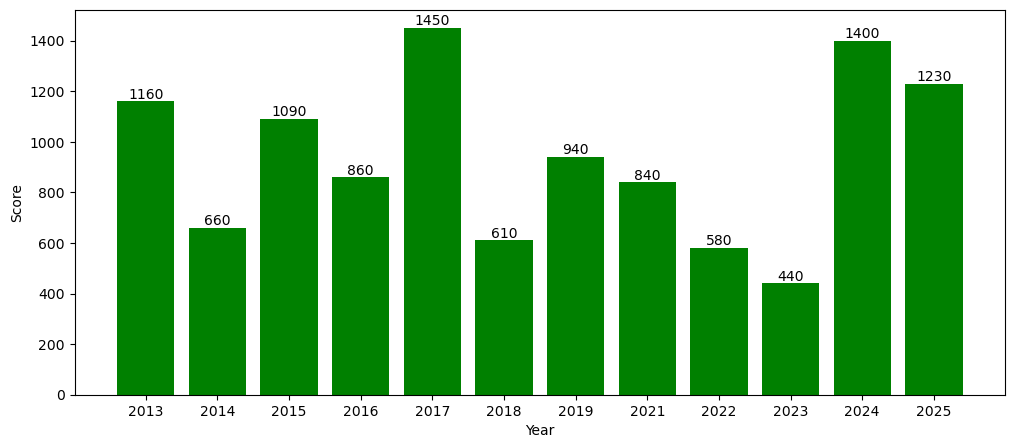

Average: 938.333
Avg. Differential: 0.693


2020's Average: 815.0
2020's Avg. Differential: 0.732


In [604]:
def bracket_check(df, years):  
    
    scores = []

    for year in years:

        score = 0

        score = score + (10 * (len(df[(df["YEAR"] == year) & (df["Wins"] > 0) & (df["Sim_Wins"] > 0)])))
        score = score + (20 * (len(df[(df["YEAR"] == year) & (df["Wins"] > 1) & (df["Sim_Wins"] > 1)])))
        score = score + (40 * (len(df[(df["YEAR"] == year) & (df["Wins"] > 2) & (df["Sim_Wins"] > 2)])))
        score = score + (80 * (len(df[(df["YEAR"] == year) & (df["Wins"] > 3) & (df["Sim_Wins"] > 3)])))
        score = score + (160 * (len(df[(df["YEAR"] == year) & (df["Wins"] > 4) & (df["Sim_Wins"] > 4)])))
        score = score + (320 * (len(df[(df["YEAR"] == year) & (df["Wins"] > 5) & (df["Sim_Wins"] > 5)])))

        scores.append(score)

    x = np.arange(len(years))

    plt.figure(figsize=(12, 5))

    plt.bar(x, scores, color='g', label='Score')

    plt.xlabel('Year')
    plt.ylabel('Score')
    plt.xticks(x, years)
    for i, score in enumerate(scores):
               plt.text(i, score, str(score), ha='center', va='bottom') 

    plt.show()
    
    df["Diff"] = abs(df["Wins"] - df["Sim_Wins"])
    
    avg = sum(scores) / len(scores)
    avgdiff = sum(df["Diff"]) / len(df["Diff"])

    print("Average:", round(avg, 3))
    print("Avg. Differential:", round(avgdiff, 3))

    
    df_recent = df[df["YEAR"] > 2020]
    scores_recent = scores[7:11]
    
    recavg = sum(scores_recent) / len(scores_recent)
    recavgdiff = sum(df_recent["Diff"]) / len(df_recent["Diff"])
    
    print("\n")
    print("2020's Average:", round(recavg, 3))
    print("2020's Avg. Differential:", round(recavgdiff, 3))
    
bracket_check(df, years)

We can now see that this model's average score is 938, which is respectable. It performs particularly well in the years 2017, 2024, and 2025, which is expected because most of the top teams made it very far these years. However, it struggles in more chaotic years, like 2023, 2022, 2018, and 2014.

I tested multiple variations of this model using these features, mostly trying different `alpha` values. I settled with this one, which uses `alpha = 0.3`, because it had the best bracket scores.
 

Since I now had everything I needed in one dataset, I could do some exploratory analysis.

For example: analyze the top 10 teams in a given year according to my model:

In [605]:
df[(df["YEAR"] == 2025)].sort_values(["Proj_Wins"], ascending=False).head(10)

,YEAR,TEAM,SEED,QUAD ID,Proj_Wins,Wins,Sim_Wins,Diff
15,2025,Duke,1,2,5.097104,4,6,2
16,2025,Florida,1,3,4.932930,6,5,1
6,2025,Auburn,1,4,4.621779,4,4,0
21,2025,Houston,1,1,4.321864,5,4,1
53,2025,Tennessee,2,1,3.118143,3,3,0
1,2025,Alabama,2,2,3.030345,3,3,0
34,2025,Michigan St.,2,4,2.389963,3,3,0
52,2025,St. John's,2,3,2.281974,1,3,2
56,2025,Texas Tech,3,3,1.986653,3,2,1
4,2025,Arizona,4,2,1.783906,2,2,0


I could also see the top 10 teams pre-tournament according to KenPom:

In [606]:
data[(data["YEAR"] == 2025)].sort_values("KADJ EM", ascending = False)[["TEAM", "KADJ EM"]].head(10)

,TEAM,KADJ EM
15,Duke,38.1518
16,Florida,35.8258
21,Houston,35.4439
6,Auburn,35.0385
53,Tennessee,31.4386
1,Alabama,29.9064
56,Texas Tech,28.0555
34,Michigan St.,27.5664
18,Gonzaga,27.2891
23,Iowa St.,27.0002


Since the sum of assigned `Proj_Wins` is not standardized to 63 (The experimental amount of wins in an actual tournament), we can check which years have the *best* field, according to the model:

In [607]:
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024, 2025]

for year in years:
    
    szn = df[df["YEAR"] == year]
    print(year, ":", szn["Proj_Wins"].sum())
    
print("Average: ", df["Proj_Wins"].sum() / len(df["YEAR"].unique()))

2013 : 60.407657592565386
2014 : 66.37305993936519
2015 : 70.57790042359295
2016 : 57.35466407403965
2017 : 66.30005620653606
2018 : 55.75772476530473
2019 : 67.90979217696936
2021 : 57.48726224926143
2022 : 57.462225064439224
2023 : 56.60454665680706
2024 : 63.08366380439904
2025 : 83.32942035699722
Average:  63.55399777585645


We can see here that 2025 truly was the best field of teams analytically in recent years, with an outlier 83 assigned wins. Aside from this, though, most years do fall just slightly over/under the expected 63 win total. In fact, the average is actually 63, right where we would expect it.

We can also check the best teams by seed according to our model:

In [608]:
df[df["SEED"] == 12].sort_values("Proj_Wins", ascending=False).head(10)

,YEAR,TEAM,SEED,QUAD ID,Proj_Wins,Wins,Sim_Wins,Diff
785,2013,Mississippi,12,3,0.853323,1,0,1
798,2013,Oregon,12,4,0.784069,2,0,2
58,2025,UC San Diego,12,4,0.764422,0,0,0
720,2014,North Carolina St.,12,1,0.751393,0,0,0
748,2013,Akron,12,2,0.724066,0,0,0
699,2014,Harvard,12,3,0.692763,1,0,1
144,2023,College of Charleston,12,4,0.686619,0,0,0
95,2024,James Madison,12,2,0.682582,1,0,1
376,2019,New Mexico St.,12,1,0.678692,0,0,0
503,2017,Middle Tennessee,12,1,0.670790,1,0,1


Let's see how many teams are projected to win at least 1 game each year according to the model:

In [609]:
for year in years:
    
    szn = df[df["YEAR"] == year]
    print(year, ":", len(szn[szn["Proj_Wins"] >= 1]))
    
print("Average: ", len(df[df["Proj_Wins"] >= 1]) / len(df["YEAR"].unique()))

2013 : 21
2014 : 28
2015 : 24
2016 : 22
2017 : 26
2018 : 19
2019 : 24
2021 : 21
2022 : 17
2023 : 16
2024 : 22
2025 : 33
Average:  22.75


Once again, 2025 is a huge outier here.

Now let's check out the best of the best teams since 2013 according to the model; teams projected to win >4 games:

In [610]:
df[df["Proj_Wins"] >= 4].sort_values("Proj_Wins", ascending=False)

,YEAR,TEAM,SEED,QUAD ID,Proj_Wins,Wins,Sim_Wins,Diff
637,2015,Kentucky,1,4,8.803521,4,6,2
15,2025,Duke,1,2,5.097104,4,6,2
16,2025,Florida,1,3,4.932930,6,5,1
6,2025,Auburn,1,4,4.621779,4,4,0
676,2015,Wisconsin,1,3,4.368352,5,4,1
21,2025,Houston,1,1,4.321864,5,4,1
349,2019,Duke,1,4,4.253756,3,6,3


There are 2 major takeaways I can see from this:

1. 2015 Kentucky has a ridiculous 8.8 projected wins
    - This number represents the fact that there was no team close to 2015 Kentucky analytically from 2008-2014 (the data this was trained on) according to the model.
    - It is especially impressive considering no team has more than 6 wins in the training data

2. 2025 has **FOUR** of the top six teams since 2013 according to the model
    - This goes to show why all four 1 seeds made the Final 4 in 2025; they were **ALL** amongst the best teams in recent memory
    - It is noteworthy that every team on this list *AT LEAST* made the Elite 8, with 6/7 making the Final 4 (numbers don't lie!)

Another interesting thing to look at is upsets that the model predicts, let's look at double-digit seeded teams with `Sim_Wins` > 0:

In [611]:
df[(df["SEED"] > 9) & (df["Sim_Wins"] > 0)]

,YEAR,TEAM,SEED,QUAD ID,Proj_Wins,Wins,Sim_Wins,Diff
108,2024,New Mexico,11,3,1.024565,0,1,1
142,2023,Boise St.,10,1,0.728062,0,1,1
198,2023,Utah St.,10,4,0.834491,0,1,1
237,2022,Michigan,11,2,0.735482,2,1,1
319,2021,Rutgers,10,1,0.779881,1,1,0
415,2018,Butler,10,2,0.709601,1,1,0
448,2018,Oklahoma,10,1,0.637343,0,1,1
462,2018,Texas,10,4,0.820540,0,1,1
540,2017,Wichita St.,10,1,1.493078,1,1,0
592,2016,Syracuse,10,1,0.624383,4,1,3


Now that my poisson regression model to calculate projected wins was complete, it was time to start working on the round advancement model

The goal of this model is to use a logistic regression to predict the chances of each team reaching a certain round of the tournament based on historical data.

To do this, we first need a column for each round. Each team will either have a 1 if they advanced to that round, or a 0 if they did not:

In [612]:
data = pd.read_csv("data/data_official.csv")

data['R32'] = [0 for _ in range(len(data))]
data['S16'] = [0 for _ in range(len(data))]
data['E8'] = [0 for _ in range(len(data))]
data['F4'] = [0 for _ in range(len(data))]
data['CHAMP'] = [0 for _ in range(len(data))]

data.loc[data['Wins'] > 0, 'R32'] = 1
data.loc[data['Wins'] > 1, 'S16'] = 1
data.loc[data['Wins'] > 2, 'E8'] = 1
data.loc[data['Wins'] > 3, 'F4'] = 1
data.loc[data['Wins'] > 5, 'CHAMP'] = 1

data['2PT%']  = data['2PT%'].div(100).round(3)
data['2PT%D'] = data['2PT%D'].div(100).round(3)
data['2PTR']  = data['2PTR'].div(100).round(3)
data['2PTRD'] = data['2PTRD'].div(100).round(3)
data['3PT%']  = data['3PT%'].div(100).round(3)
data['3PT%D'] = data['3PT%D'].div(100).round(3)
data['3PTR']  = data['3PTR'].div(100).round(3)
data['3PTRD'] = data['3PTRD'].div(100).round(3)
data['FT%']   = data['FT%'].div(100).round(3)
data['FTR']   = data['FTR'].div(100).round(3)
data['FTRD']  = data['FTRD'].div(100).round(3)
data['TOV%']  = data['TOV%'].div(100).round(3)
data['TOV%D'] = data['TOV%D'].div(100).round(3)
data['OREB%'] = data['OREB%'].div(100).round(3)
data['DREB%'] = data['DREB%'].div(100).round(3)
data['EFG%']  = data['EFG%'].div(100).round(3)
data['EFG%D'] = data['EFG%D'].div(100).round(3)
data['AST%']  = data['AST%'].div(100).round(3)

Now that we have all the columns we will need for this model, let's quickly remove some that we don't:

In [613]:
drop = ["YEAR", "CONF", "TEAM", "CONF ID", "QUAD ID", "QUAD NO", "TEAM NO", "TEAM ID", "ROUND"]

df = data.drop(drop, axis=1)

columns = df.columns.to_list()

We will now follow and repeat a similar process that was used to find the optimal features for each round that we used to find the optimal features for `Wins` previously:

In [614]:
# ROUND OF 32

In [615]:
corr = abs(df.corr()["R32"]).sort_values(ascending=False)
filtered = corr[corr >= 0.1]
print(filtered.sort_values(ascending=False).index)

Index(['R32', 'Wins', 'S16', 'SEED', 'BADJ EM', 'KADJ EM', 'WAB', 'BARTHAG',
       'BARTHAG RANK', 'BADJ EM RANK', 'KADJ EM RANK', 'TALENT',
       'ELITE SOS RANK', 'ELITE SOS', 'BADJ D RANK', 'BADJ O', 'KADJ D RANK',
       'BADJ D', 'KADJ D', 'KADJ O', 'TALENT RANK', 'BADJ O RANK',
       'KADJ O RANK', 'E8', 'W', 'WIN%', 'PPPO RANK', 'PPPO', 'KO RANK', 'L',
       'K OFF', 'F4', 'AVG HGT RANK', 'AVG HGT', 'PPPD RANK', 'PPPD',
       'KD RANK', 'K DEF', 'EFF HGT RANK', 'OREB% RANK', 'OP DREB% RANK',
       'EFGD% RANK', 'EFG%D', 'EFF HGT', 'TOV% RANK', 'OP DREB%', 'OREB%',
       'BLK% RANK', 'BLK%', '2PT%D RANK', '2PT%D', 'TOV%', 'GAMES',
       'EFG% RANK', '2PT% RANK', 'EFG%', '2PT%', 'EXP', 'CHAMP', 'FTRD',
       'FTRD RANK', '3PT%D', 'AST% RANK', '3PT%D RANK', 'AST%', 'EXP RANK'],
      dtype='object')


In [616]:
optimal = ['WAB', 'KADJ D', 'KADJ O', 'EFF HGT', 'OREB%', '2PT%D', 'TOV%', '2PT%', 'EXP', 'FTRD', '3PT%D', 'AST%', '3PT%']

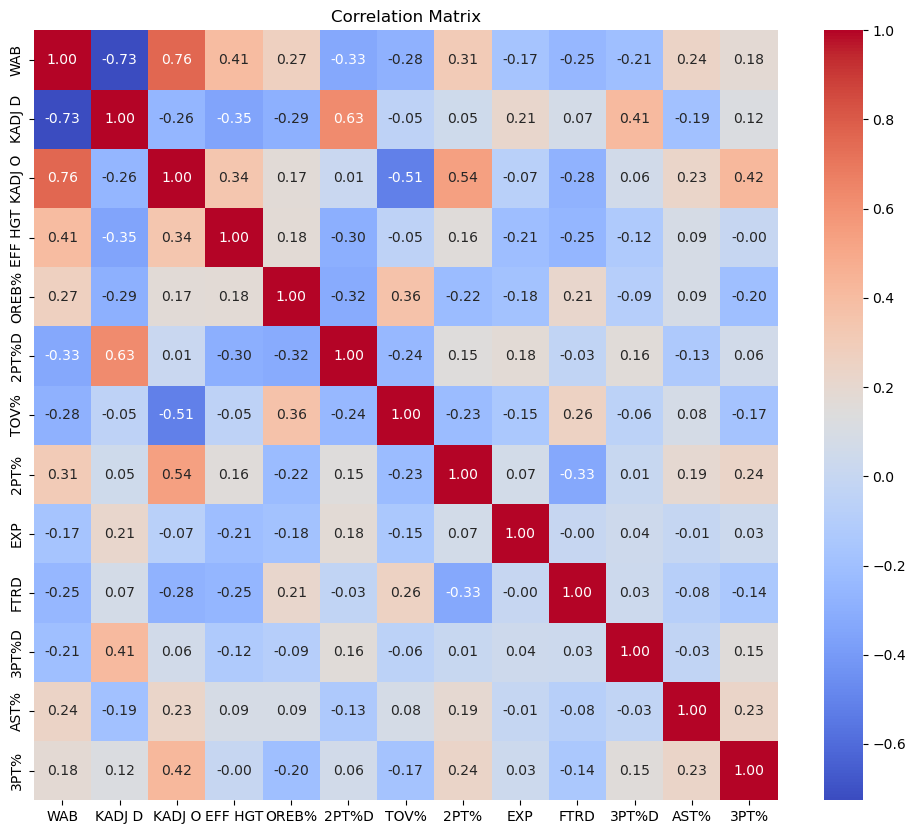

In [617]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

corr_matrix = df[optimal].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [618]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df[optimal]
X = add_constant(X)  

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))

    Feature          VIF
0     const  9686.315824
3    KADJ O     9.435615
1       WAB     8.289820
2    KADJ D     5.581972
7      TOV%     2.775874
5     OREB%     2.631687
8      2PT%     2.360411
6     2PT%D     2.101001
13     3PT%     1.864544
4   EFF HGT     1.418160
11    3PT%D     1.378131
10     FTRD     1.289008
12     AST%     1.183181
9       EXP     1.121417


In [619]:
# SWEET 16

In [620]:
corr = abs(df.corr()["S16"]).sort_values(ascending=False)
filtered = corr[corr >= 0.1]
print(filtered.sort_values(ascending=False).index)

Index(['S16', 'Wins', 'E8', 'R32', 'SEED', 'WAB', 'BADJ EM', 'KADJ EM', 'F4',
       'BADJ O', 'KADJ O', 'TALENT', 'BARTHAG', 'BARTHAG RANK', 'BADJ EM RANK',
       'KADJ EM RANK', 'ELITE SOS', 'KADJ D', 'BADJ D', 'ELITE SOS RANK',
       'TALENT RANK', 'W', 'BADJ O RANK', 'KADJ O RANK', 'BADJ D RANK',
       'KADJ D RANK', 'WIN%', 'PPPO', 'K OFF', 'L', 'PPPO RANK', 'KO RANK',
       'AVG HGT', 'EFF HGT', 'AVG HGT RANK', 'EFF HGT RANK', 'CHAMP', 'PPPD',
       'K DEF', 'EFG%D', 'PPPD RANK', 'KD RANK', 'OREB% RANK', 'OP DREB% RANK',
       'EFG%', 'EFGD% RANK', 'OP DREB%', 'OREB%', 'EFG% RANK', '2PT%', 'BLK%',
       '2PT%D', 'BLK% RANK', 'TOV% RANK', '2PT% RANK', '2PT%D RANK', 'GAMES',
       'TOV%', 'FTRD RANK', 'FTRD', 'BLKED% RANK', 'EXP', 'BLKED%', '3PT%D',
       'EXP RANK', '3PT%', '3PT% RANK'],
      dtype='object')


In [621]:
optimal = ['WAB', 'KADJ O', 'KADJ D', 'EFF HGT', 'OREB%', '2PT%', '2PT%D', 'TOV%', 'FTRD', 'EXP', '3PT%D', '3PT%']

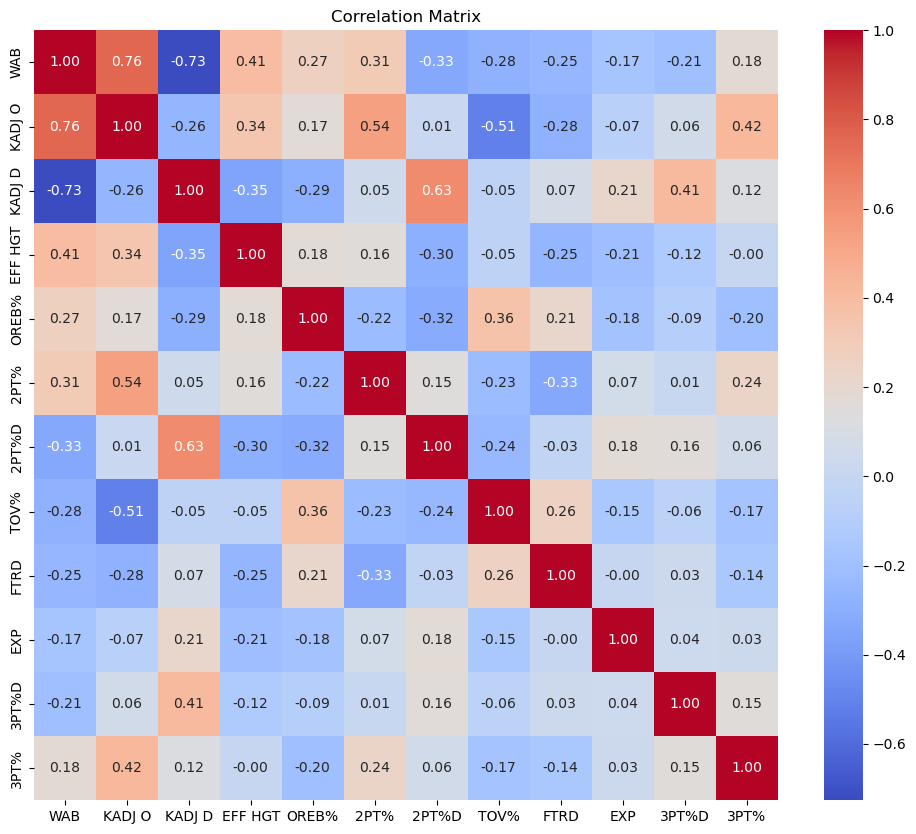

In [622]:
corr_matrix = df[optimal].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [623]:
X = df[optimal]
X = add_constant(X)  

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))

    Feature          VIF
0     const  9628.074381
2    KADJ O     9.419782
1       WAB     8.289795
3    KADJ D     5.534691
8      TOV%     2.731281
5     OREB%     2.630216
6      2PT%     2.338763
7     2PT%D     2.100988
12     3PT%     1.811880
4   EFF HGT     1.416830
11    3PT%D     1.377708
9      FTRD     1.288109
10      EXP     1.117885


In [624]:
# ELITE 8

In [625]:
corr = abs(df.corr()["E8"]).sort_values(ascending=False)
filtered = corr[corr >= 0.09]
print(filtered.sort_values(ascending=False).index)

Index(['E8', 'Wins', 'F4', 'S16', 'SEED', 'WAB', 'R32', 'BADJ EM', 'KADJ EM',
       'CHAMP', 'BADJ O', 'KADJ O', 'W', 'TALENT', 'WIN%', 'BARTHAG', 'L',
       'PPPO', 'KADJ D', 'BADJ EM RANK', 'BARTHAG RANK', 'KADJ EM RANK',
       'K OFF', 'ELITE SOS', 'BADJ D', 'BADJ O RANK', 'ELITE SOS RANK',
       'TALENT RANK', 'KADJ O RANK', 'BADJ D RANK', 'KADJ D RANK', 'PPPO RANK',
       'KO RANK', 'OP DREB% RANK', 'OREB% RANK', 'OP DREB%', 'OREB%',
       'EFF HGT', 'EFF HGT RANK', 'K DEF', 'AVG HGT', 'PPPD', '2PT%', 'EFG%',
       'EFG%D', 'EFG% RANK', '2PT% RANK', 'BLK%', 'AVG HGT RANK', 'EFGD% RANK',
       'KD RANK', 'PPPD RANK', '2PT%D', 'TOV% RANK', 'GAMES', '2PT%D RANK',
       'BLK% RANK', 'TOV%', 'BLKED% RANK', 'BLKED%', 'EXP', 'FTRD', '3PT%D'],
      dtype='object')


In [626]:
optimal = ['WAB', 'KADJ O', 'KADJ D', 'OREB%', 'EFF HGT', '2PT%', '2PT%D', 'TOV%', 'EXP', 'FTRD', '3PT%D']

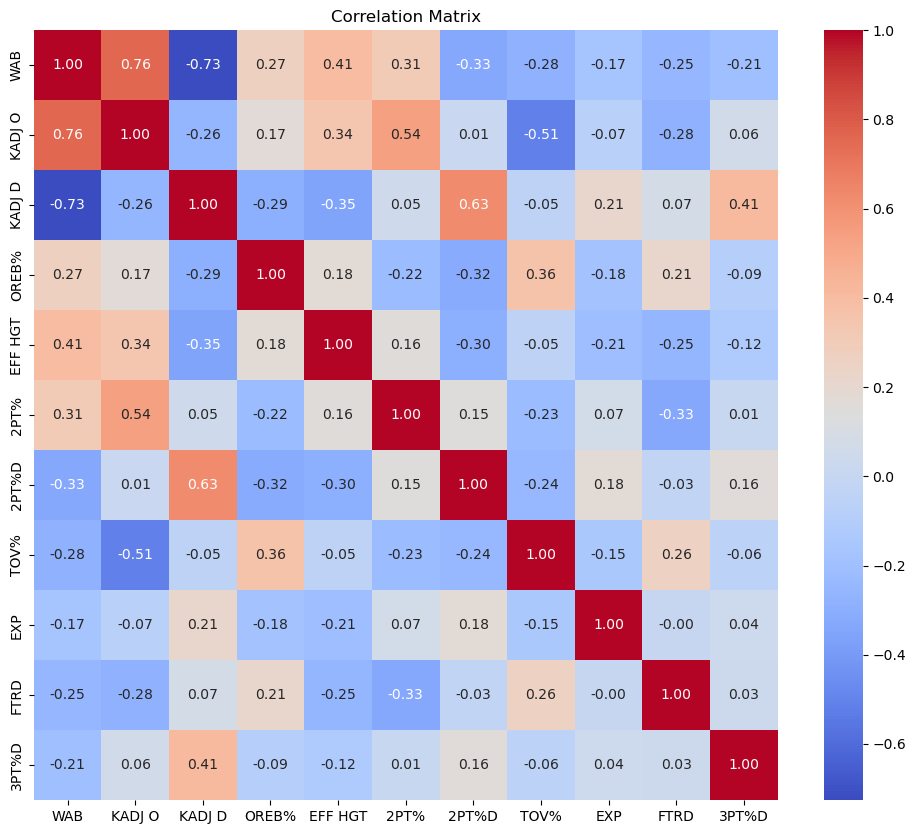

In [627]:
corr_matrix = df[optimal].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [628]:
X = df[optimal]
X = add_constant(X)  

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))

    Feature          VIF
0     const  9502.637914
1       WAB     8.274515
2    KADJ O     6.896851
3    KADJ D     5.287454
8      TOV%     2.310320
6      2PT%     2.104274
4     OREB%     2.018696
7     2PT%D     1.968111
5   EFF HGT     1.377206
11    3PT%D     1.364990
10     FTRD     1.287057
9       EXP     1.116110


In [629]:
# FINAL 4

In [630]:
corr = abs(df.corr()["F4"]).sort_values(ascending=False)
filtered = corr[corr >= 0.088]
print(filtered.sort_values(ascending=False).index)

Index(['F4', 'Wins', 'E8', 'CHAMP', 'S16', 'WAB', 'SEED', 'BADJ EM', 'KADJ EM',
       'R32', 'W', 'BADJ O', 'KADJ O', 'WIN%', 'L', 'TALENT', 'PPPO', 'K OFF',
       'KADJ D', 'BADJ D', 'BARTHAG', 'BADJ EM RANK', 'BARTHAG RANK',
       'KADJ EM RANK', 'BADJ O RANK', 'KADJ O RANK', 'TALENT RANK',
       'ELITE SOS', 'BADJ D RANK', 'ELITE SOS RANK', 'KADJ D RANK',
       'PPPO RANK', 'KO RANK', 'PPPD', 'K DEF', 'OP DREB%', 'OREB%',
       'OP DREB% RANK', 'OREB% RANK', 'EFG%D', 'KD RANK', 'PPPD RANK', '2PT%D',
       'AVG HGT', 'EFG%', 'BLK%', 'EFG% RANK', 'EFGD% RANK', 'GAMES',
       'TOV% RANK', 'EFF HGT', 'AVG HGT RANK', '2PT%D RANK', 'EFF HGT RANK',
       'TOV%', 'FTRD'],
      dtype='object')


In [631]:
optimal = ['WAB', 'KADJ O', 'KADJ D', 'OREB%', 'EFG%D', 'EFG%', 'EFF HGT', 'TOV%', 'FTRD']

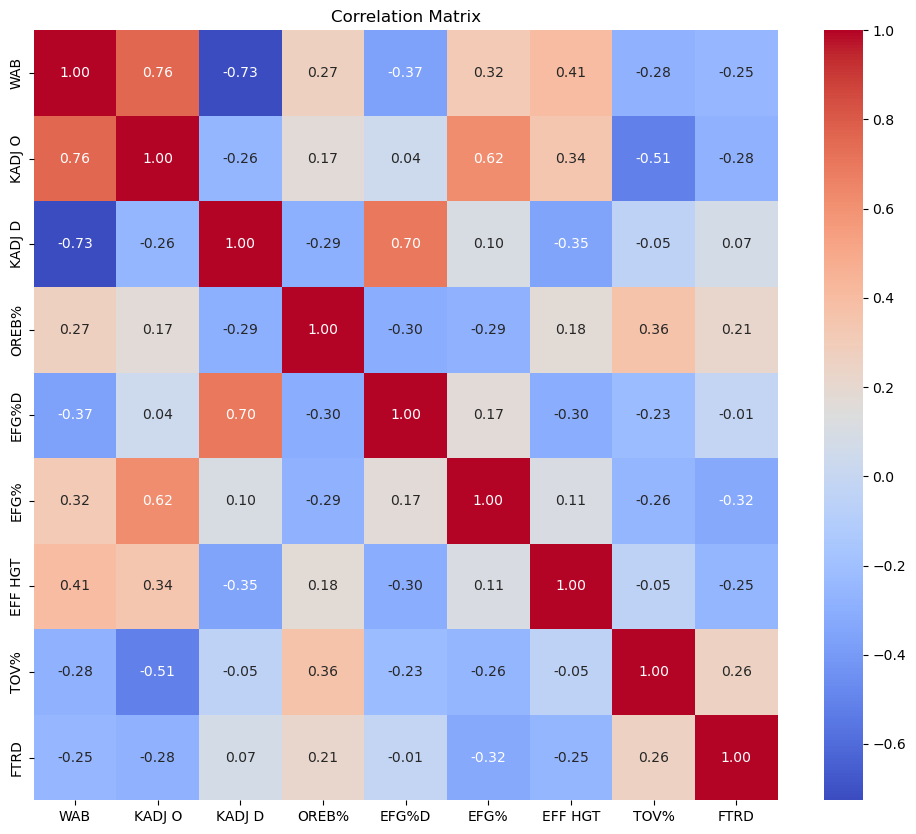

In [632]:
corr_matrix = df[optimal].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [633]:
X = df[optimal]
X = add_constant(X)  

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))

   Feature          VIF
0    const  9295.718268
2   KADJ O     9.453471
1      WAB     8.270679
3   KADJ D     5.472983
6     EFG%     3.472674
4    OREB%     2.719807
8     TOV%     2.678313
5    EFG%D     2.504268
7  EFF HGT     1.382763
9     FTRD     1.277300


In [634]:
# NATIONAL CHAMPION

In [635]:
corr = abs(df.corr()["CHAMP"]).sort_values(ascending=False)
filtered = corr[corr >= 0.08]
print(filtered.sort_values(ascending=False).index)

Index(['CHAMP', 'F4', 'Wins', 'E8', 'S16', 'WAB', 'BADJ EM', 'KADJ EM', 'SEED',
       'BADJ O', 'KADJ O', 'W', 'PPPO', 'WIN%', 'K OFF', 'L', 'TALENT', 'R32',
       'KADJ D', 'BARTHAG', 'BADJ D', 'OP DREB%', 'OREB%', 'ELITE SOS',
       'BADJ EM RANK', 'PPPO RANK', 'BARTHAG RANK', 'KADJ EM RANK', 'KO RANK',
       'BADJ O RANK', 'KADJ O RANK', 'TALENT RANK', 'BADJ D RANK',
       'ELITE SOS RANK', 'KADJ D RANK', 'OREB% RANK', 'OP DREB% RANK', 'EFG%D',
       'PPPD', 'PPPD RANK', 'K DEF', 'KD RANK', 'BLK%', 'EFGD% RANK', 'EFG%'],
      dtype='object')


In [636]:
optimal = ['WAB', 'KADJ O', 'KADJ D', 'OREB%', 'EFG%D', 'EFG%']

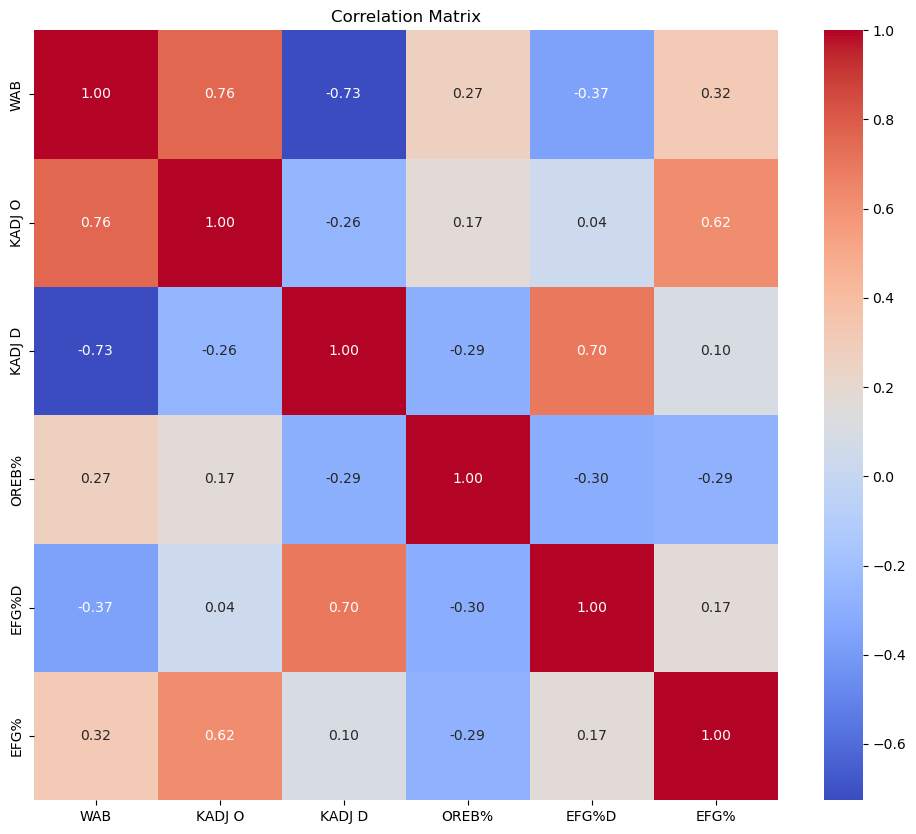

In [637]:
corr_matrix = df[optimal].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [638]:
X = df[optimal]
X = add_constant(X)  

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))

  Feature          VIF
0   const  1115.084402
1     WAB     8.115391
2  KADJ O     5.749165
3  KADJ D     5.335556
6    EFG%     2.440403
5   EFG%D     2.376216
4   OREB%     1.506601


*No testing process for round advancement yet*